# SAMPIC Timing Analysis

Comprehensive analysis of SAMPIC event and collector timing metrics.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Paths
DATA_FILE = "../../output.root"
BUILD_LIB_PATH = "../../build/lib"

## Load Libraries and Data

In [2]:
# Load SAMPIC data product libraries
libs_to_load = [
    "libanalysis_pipeline_core.so",
    "libunpacker_data_products_core.so",
    "libunpacker_data_products_sampic.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        print(f"Loading {lib}...")
        ROOT.gSystem.Load(path)
    else:
        print(f"Warning: {lib} not found")

Loading libanalysis_pipeline_core.so...
Loading libunpacker_data_products_core.so...
Loading libunpacker_data_products_sampic.so...


In [3]:
# Open the ROOT file
f = ROOT.TFile.Open(DATA_FILE)
if not f or f.IsZombie():
    print(f"Error: Could not open file {DATA_FILE}")
else:
    tree = f.Get("events")
    print(f"Number of events in file: {tree.GetEntries()}")
    print("\nAvailable branches:")
    for branch in tree.GetListOfBranches():
        print(f"  - {branch.GetName()}")

    if tree.GetBranch("has_sampic_collector_timing"):
        print("\nBranch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.")


Number of events in file: 5088

Available branches:
  - sampic_event
  - sampic_event_timing
  - sampic_collector_timing
  - has_sampic_collector_timing

Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.


## Collect Event Timing Data

In [4]:

# Collect event timing data from many events
n_events = tree.GetEntries()

# Event timing arrays
et_prepare_max = []
et_read_max = []
et_decode_max = []
et_total_max = []
et_prepare_sum = []
et_read_sum = []
et_decode_sum = []
et_total_sum = []
et_acq_retry_max = []
et_acq_retry_sum = []
et_nhits = []
et_nparents = []

# Collector timing arrays (only fill when AC00 bank present)
ct_wait = []
ct_group = []
ct_finalize = []
ct_total = []
ct_n_events = []
ct_total_hits = []
collector_present_flags = []

# Hit timing/ticker helpers
event_timestamp_ns = []
event_hit_counts = []
hit_first_cell_timestamps = []
hit_event_indices = []
event_bytes = []

for i in range(n_events):
    bytes_read = tree.GetEntry(i)

    # Event timing (should always be present)
    et = getattr(tree, "sampic_event_timing", None)
    if et:
        et_prepare_max.append(et.sp_prepare_us_max)
        et_read_max.append(et.sp_read_us_max)
        et_decode_max.append(et.sp_decode_us_max)
        et_total_max.append(et.sp_total_us_max)
        et_prepare_sum.append(et.sp_prepare_us_sum)
        et_read_sum.append(et.sp_read_us_sum)
        et_decode_sum.append(et.sp_decode_us_sum)
        et_total_sum.append(et.sp_total_us_sum)
        et_acq_retry_max.append(getattr(et, "sp_acq_retry_max", 0))
        et_acq_retry_sum.append(getattr(et, "sp_acq_retry_sum", 0))
        et_nhits.append(et.nhits)
        et_nparents.append(et.nparents)
        event_timestamp_ns.append(et.fe_timestamp_ns)
        bytes_value = int(bytes_read) if isinstance(bytes_read, (int, float)) else 0
        event_bytes.append(max(bytes_value, 0))
    else:
        collector_present_flags.append(False)
        continue

    event_idx = len(event_timestamp_ns) - 1

    # Hit details for ticker plots
    event = getattr(tree, "sampic_event", None)
    hit_count = len(event.hits) if event else 0
    event_hit_counts.append(hit_count)
    if hit_count:
        first_cell_values = [hit.first_cell_timestamp for hit in event.hits]
        hit_first_cell_timestamps.extend(first_cell_values)
        hit_event_indices.extend([event_idx] * hit_count)

    has_collector = bool(getattr(tree, "has_sampic_collector_timing", False))
    collector_present_flags.append(has_collector)

    if has_collector:
        ct = getattr(tree, "sampic_collector_timing", None)
        if ct:
            ct_wait.append(ct.wait_us)
            ct_group.append(ct.group_build_us)
            ct_finalize.append(ct.finalize_us)
            ct_total.append(ct.total_us)
            ct_n_events.append(ct.n_events)
            ct_total_hits.append(ct.total_hits)

# Convert to numpy arrays
et_prepare_max = np.array(et_prepare_max)
et_read_max = np.array(et_read_max)
et_decode_max = np.array(et_decode_max)
et_total_max = np.array(et_total_max)
et_prepare_sum = np.array(et_prepare_sum)
et_read_sum = np.array(et_read_sum)
et_decode_sum = np.array(et_decode_sum)
et_total_sum = np.array(et_total_sum)
et_acq_retry_max = np.array(et_acq_retry_max)
et_acq_retry_sum = np.array(et_acq_retry_sum)
et_nhits = np.array(et_nhits)
et_nparents = np.array(et_nparents)

collector_presence = np.array(collector_present_flags, dtype=bool)
ct_wait = np.array(ct_wait)
ct_group = np.array(ct_group)
ct_finalize = np.array(ct_finalize)
ct_total = np.array(ct_total)
ct_n_events = np.array(ct_n_events)
ct_total_hits = np.array(ct_total_hits)

event_timestamp_ns = np.array(event_timestamp_ns, dtype=np.int64)
event_hit_counts = np.array(event_hit_counts, dtype=np.int32)
hit_first_cell_timestamps = np.array(hit_first_cell_timestamps, dtype=float)
hit_event_indices = np.array(hit_event_indices, dtype=np.int32)
event_bytes = np.array(event_bytes, dtype=np.int64)
event_indices = np.arange(event_timestamp_ns.size, dtype=np.int32)

event_times_s = (event_timestamp_ns - event_timestamp_ns[0]) * 1e-9 if event_timestamp_ns.size else np.array([])
inter_event_dt_s = np.diff(event_timestamp_ns) * 1e-9 if event_timestamp_ns.size > 1 else np.array([])
valid_dt_mask = inter_event_dt_s > 0
event_rate_hz = np.full_like(inter_event_dt_s, np.nan, dtype=float)
event_rate_hz[valid_dt_mask] = 1.0 / inter_event_dt_s[valid_dt_mask]
event_rate_event_idx = event_indices[1:] if event_indices.size > 1 else np.array([])

bytes_for_rate = event_bytes[1:].astype(float) if event_bytes.size > 1 else np.array([])
data_rate_bps = np.full_like(inter_event_dt_s, np.nan, dtype=float)
if bytes_for_rate.size:
    data_valid_mask = valid_dt_mask & (bytes_for_rate > 0)
    data_rate_bps[data_valid_mask] = bytes_for_rate[data_valid_mask] / inter_event_dt_s[data_valid_mask]
data_rate_event_idx = event_indices[1:] if event_indices.size > 1 else np.array([])
cumulative_data_mb = np.cumsum(event_bytes) / 1e6 if event_bytes.size else np.array([])

total_span_s = float((event_timestamp_ns[-1] - event_timestamp_ns[0]) * 1e-9) if event_timestamp_ns.size > 1 else float("nan")
if np.isfinite(total_span_s) and total_span_s > 0:
    avg_event_rate_hz = len(event_timestamp_ns) / total_span_s
    avg_hit_rate_hz = event_hit_counts.sum() / total_span_s if event_hit_counts.size else float("nan")
    avg_data_rate_bps = event_bytes.sum() / total_span_s if event_bytes.size else float("nan")
else:
    avg_event_rate_hz = float("nan")
    avg_hit_rate_hz = float("nan")
    avg_data_rate_bps = float("nan")

collector_fraction = (collector_presence.mean() * 100.0) if collector_presence.size else 0.0
present_count = int(collector_presence.sum()) if collector_presence.size else 0
total_data_bytes = event_bytes.sum() if event_bytes.size else 0.0

print()
print(f"Collected timing data from {n_events} events")
print(f"Event timing entries: {len(et_total_max)}")
print(f"Collector timing entries: {present_count} ({collector_fraction:.1f}% of events)")
print(f"Total recorded hits: {int(event_hit_counts.sum()) if event_hit_counts.size else 0}")
print(f"Total data read: {total_data_bytes / 1e6:.2f} MB")



Collected timing data from 5088 events
Event timing entries: 5088
Collector timing entries: 4469 (87.8% of events)
Total recorded hits: 173052
Total data read: 59.98 MB


## Event Timing Distributions

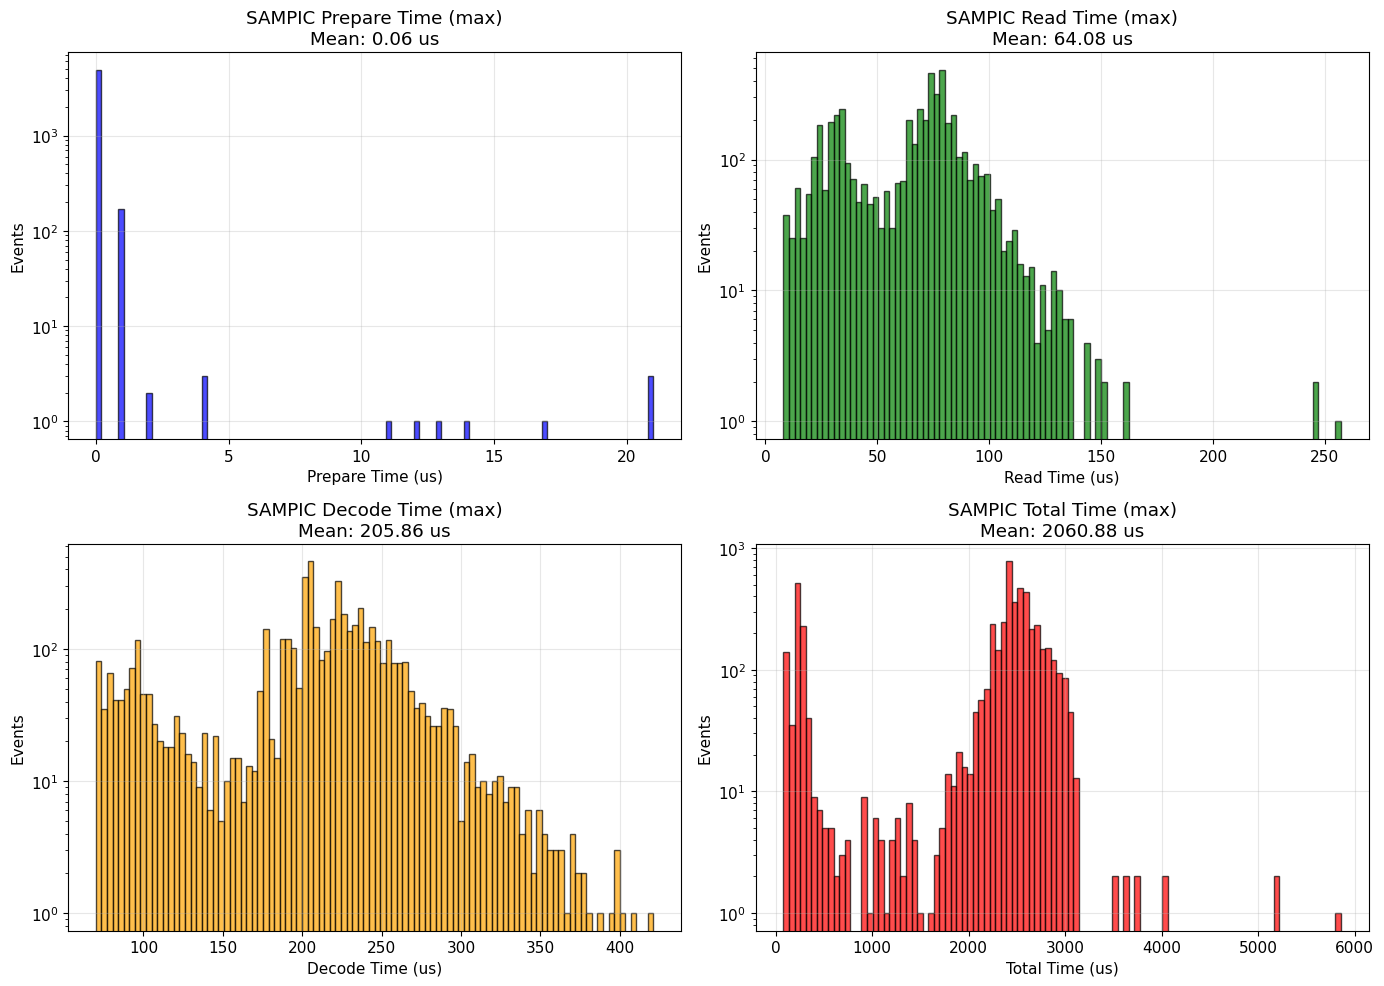

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prepare time
axes[0, 0].hist(et_prepare_max, bins=100, alpha=0.7, edgecolor='black', color='blue')
axes[0, 0].set_xlabel('Prepare Time (us)')
axes[0, 0].set_ylabel('Events')
axes[0, 0].set_title(f'SAMPIC Prepare Time (max)\nMean: {np.mean(et_prepare_max):.2f} us')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Read time
axes[0, 1].hist(et_read_max, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[0, 1].set_xlabel('Read Time (us)')
axes[0, 1].set_ylabel('Events')
axes[0, 1].set_title(f'SAMPIC Read Time (max)\nMean: {np.mean(et_read_max):.2f} us')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Decode time
axes[1, 0].hist(et_decode_max, bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[1, 0].set_xlabel('Decode Time (us)')
axes[1, 0].set_ylabel('Events')
axes[1, 0].set_title(f'SAMPIC Decode Time (max)\nMean: {np.mean(et_decode_max):.2f} us')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Total time
axes[1, 1].hist(et_total_max, bins=100, alpha=0.7, edgecolor='black', color='red')
axes[1, 1].set_xlabel('Total Time (us)')
axes[1, 1].set_ylabel('Events')
axes[1, 1].set_title(f'SAMPIC Total Time (max)\nMean: {np.mean(et_total_max):.2f} us')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Acquisition Retry Distributions

Histograms of retry counts captured per frontend event from the AT banks.


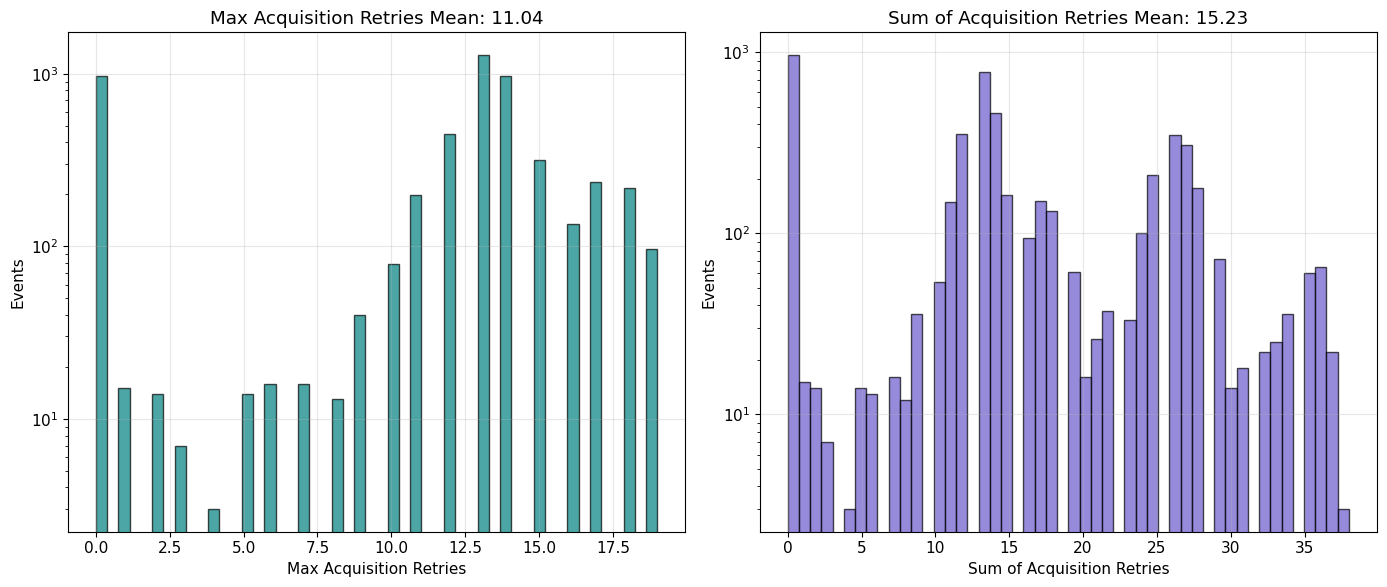

In [6]:
if et_acq_retry_max.size > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].hist(et_acq_retry_max, bins=50, alpha=0.7, edgecolor='black', color='teal')
    axes[0].set_xlabel('Max Acquisition Retries')
    axes[0].set_ylabel('Events')
    axes[0].set_title(f'Max Acquisition Retries Mean: {np.mean(et_acq_retry_max):.2f}')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(et_acq_retry_sum, bins=50, alpha=0.7, edgecolor='black', color='slateblue')
    axes[1].set_xlabel('Sum of Acquisition Retries')
    axes[1].set_ylabel('Events')
    axes[1].set_title(f'Sum of Acquisition Retries Mean: {np.mean(et_acq_retry_sum):.2f}')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print('No acquisition retry information available in this dataset.')


## Collector Timing Analysis (when available)

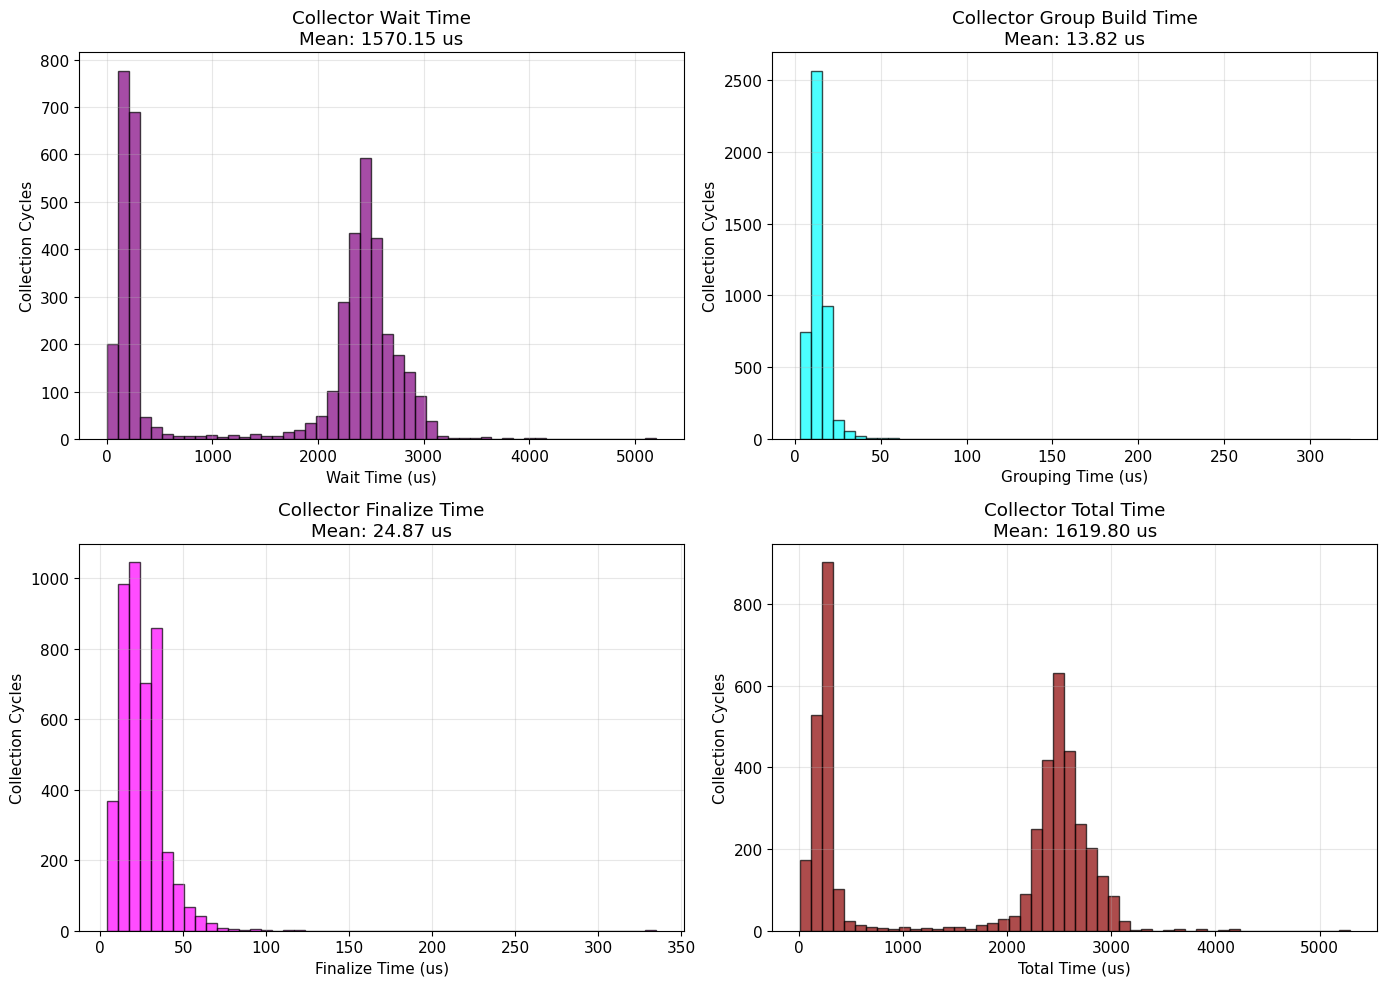

In [7]:
if len(ct_total) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Wait time
    axes[0, 0].hist(ct_wait, bins=50, alpha=0.7, edgecolor='black', color='purple')
    axes[0, 0].set_xlabel('Wait Time (us)')
    axes[0, 0].set_ylabel('Collection Cycles')
    axes[0, 0].set_title(f'Collector Wait Time\nMean: {np.mean(ct_wait):.2f} us')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Group time
    axes[0, 1].hist(ct_group, bins=50, alpha=0.7, edgecolor='black', color='cyan')
    axes[0, 1].set_xlabel('Grouping Time (us)')
    axes[0, 1].set_ylabel('Collection Cycles')
    axes[0, 1].set_title(f'Collector Group Build Time\nMean: {np.mean(ct_group):.2f} us')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Finalize time
    axes[1, 0].hist(ct_finalize, bins=50, alpha=0.7, edgecolor='black', color='magenta')
    axes[1, 0].set_xlabel('Finalize Time (us)')
    axes[1, 0].set_ylabel('Collection Cycles')
    axes[1, 0].set_title(f'Collector Finalize Time\nMean: {np.mean(ct_finalize):.2f} us')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Total time
    axes[1, 1].hist(ct_total, bins=50, alpha=0.7, edgecolor='black', color='darkred')
    axes[1, 1].set_xlabel('Total Time (us)')
    axes[1, 1].set_ylabel('Collection Cycles')
    axes[1, 1].set_title(f'Collector Total Time\nMean: {np.mean(ct_total):.2f} us')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No collector timing data available in this dataset")

## Timing vs Event Size

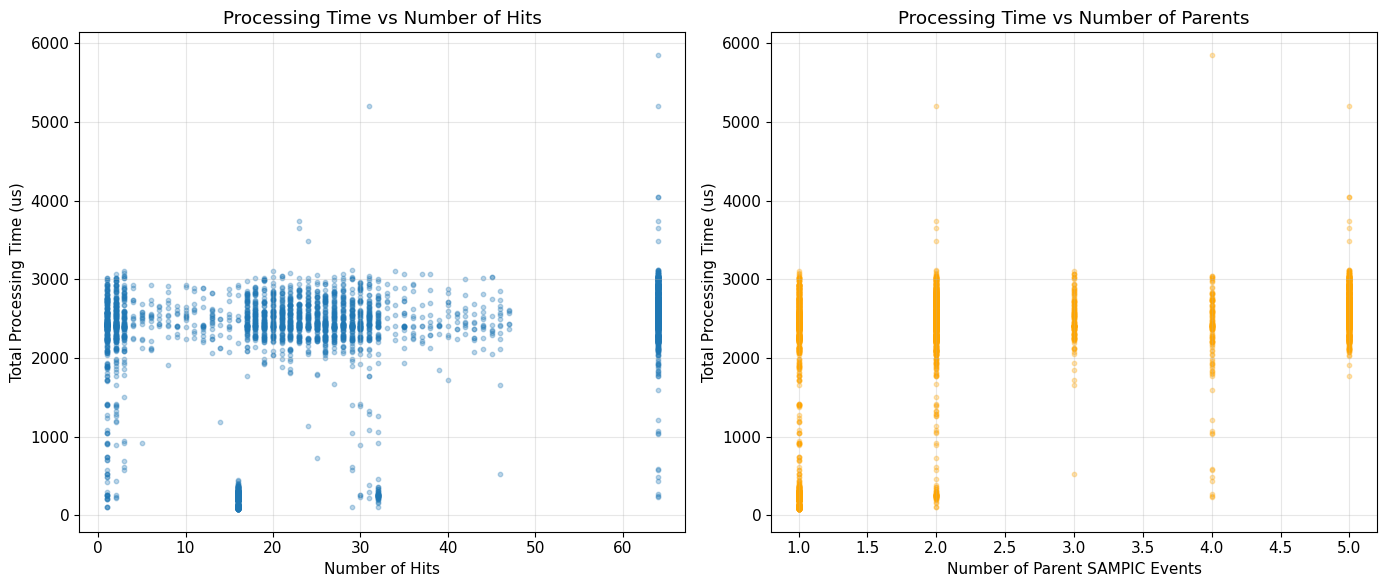

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total time vs number of hits
axes[0].scatter(et_nhits, et_total_max, alpha=0.3, s=10)
axes[0].set_xlabel('Number of Hits')
axes[0].set_ylabel('Total Processing Time (us)')
axes[0].set_title('Processing Time vs Number of Hits')
axes[0].grid(True, alpha=0.3)

# Total time vs number of parent events
axes[1].scatter(et_nparents, et_total_max, alpha=0.3, s=10, color='orange')
axes[1].set_xlabel('Number of Parent SAMPIC Events')
axes[1].set_ylabel('Total Processing Time (us)')
axes[1].set_title('Processing Time vs Number of Parents')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Hit Timestamp Ticker

Sequential view of per-hit first-cell timestamps to visualize how the detector is sampling across events.

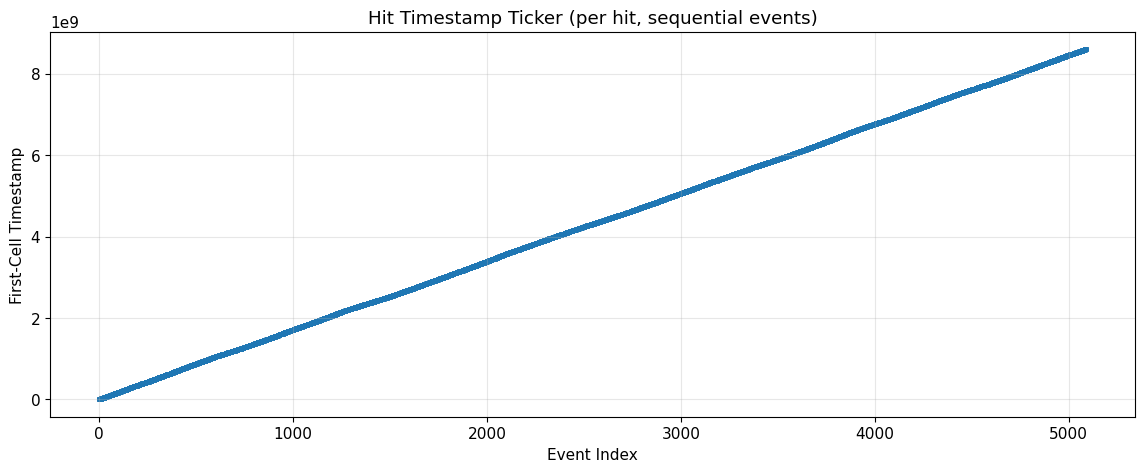

In [9]:
if hit_first_cell_timestamps.size > 0:
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(hit_event_indices, hit_first_cell_timestamps, s=6, alpha=0.4, color='tab:blue')
    ax.set_xlabel('Event Index')
    ax.set_ylabel('First-Cell Timestamp')
    ax.set_title('Hit Timestamp Ticker (per hit, sequential events)')
    ax.grid(True, alpha=0.3)
else:
    print('No hit timestamp information available for this run.')

## Event Rate Ticker

Instantaneous event spacing derived from frontend timestamps along with the overall acquisition timeline.

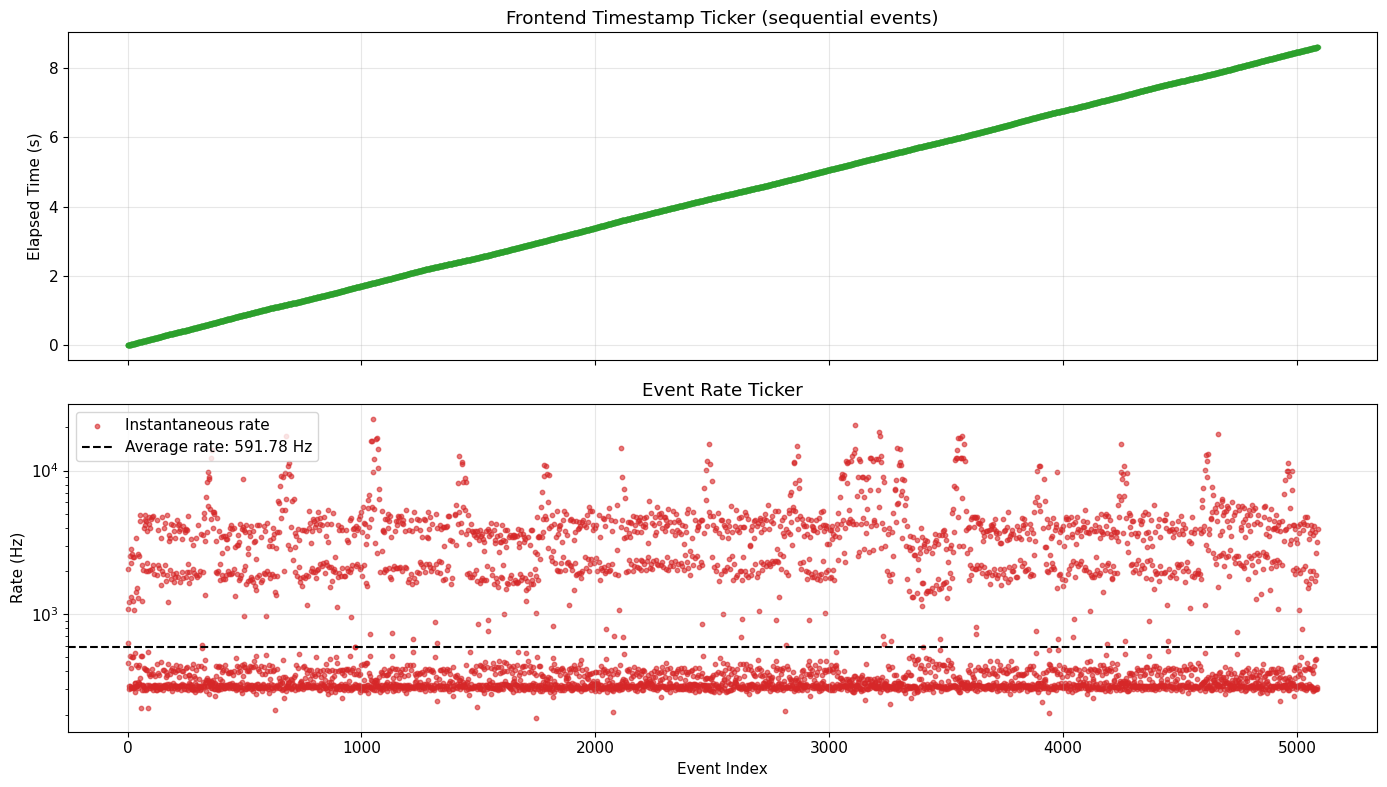

In [10]:
if event_timestamp_ns.size > 1 and event_rate_event_idx.size > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(event_indices, event_times_s, marker='.', linestyle='-', alpha=0.7, color='tab:green')
    axes[0].set_ylabel('Elapsed Time (s)')
    axes[0].set_title('Frontend Timestamp Ticker (sequential events)')
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(event_rate_event_idx, event_rate_hz, s=10, alpha=0.6, color='tab:red', label='Instantaneous rate')
    if np.isfinite(avg_event_rate_hz):
        axes[1].axhline(avg_event_rate_hz, color='black', linestyle='--', label=f'Average rate: {avg_event_rate_hz:.2f} Hz')
    axes[1].set_xlabel('Event Index')
    axes[1].set_ylabel('Rate (Hz)')
    axes[1].set_title('Event Rate Ticker')

    positive_event_rates = event_rate_hz[np.isfinite(event_rate_hz) & (event_rate_hz > 0)]
    if positive_event_rates.size > 0:
        ymin = max(positive_event_rates.min() * 0.8, 1e-6)
        axes[1].set_yscale('log')
        axes[1].set_ylim(bottom=ymin)
    else:
        axes[1].set_ylim(bottom=0)

    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print('Not enough event timestamp information to derive rates.')

## Event Rate Histogram

Distribution of instantaneous event rates to highlight the dominant operating regimes.

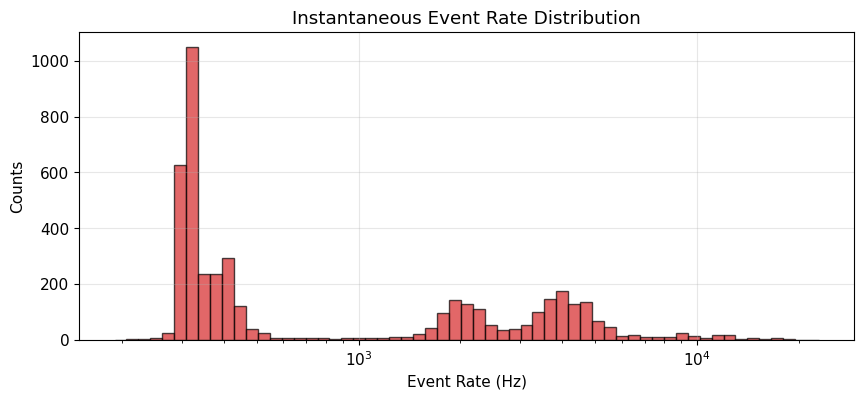

In [11]:
positive_event_rates = event_rate_hz[np.isfinite(event_rate_hz) & (event_rate_hz > 0)]
if positive_event_rates.size > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    rate_min = positive_event_rates.min()
    rate_max = positive_event_rates.max()
    if rate_min > 0 and rate_max > rate_min:
        bins = np.logspace(np.log10(rate_min), np.log10(rate_max), 60)
        ax.hist(positive_event_rates, bins=bins, color='tab:red', alpha=0.7, edgecolor='black')
        ax.set_xscale('log')
    else:
        ax.hist(positive_event_rates, bins=40, color='tab:red', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Event Rate (Hz)')
    ax.set_ylabel('Counts')
    ax.set_title('Instantaneous Event Rate Distribution')
    ax.grid(True, alpha=0.3)
else:
    print('No positive event rates available for histogram.')

## Data Rate Ticker

Cumulative throughput and instantaneous data rates derived from ROOT I/O bytes per event.

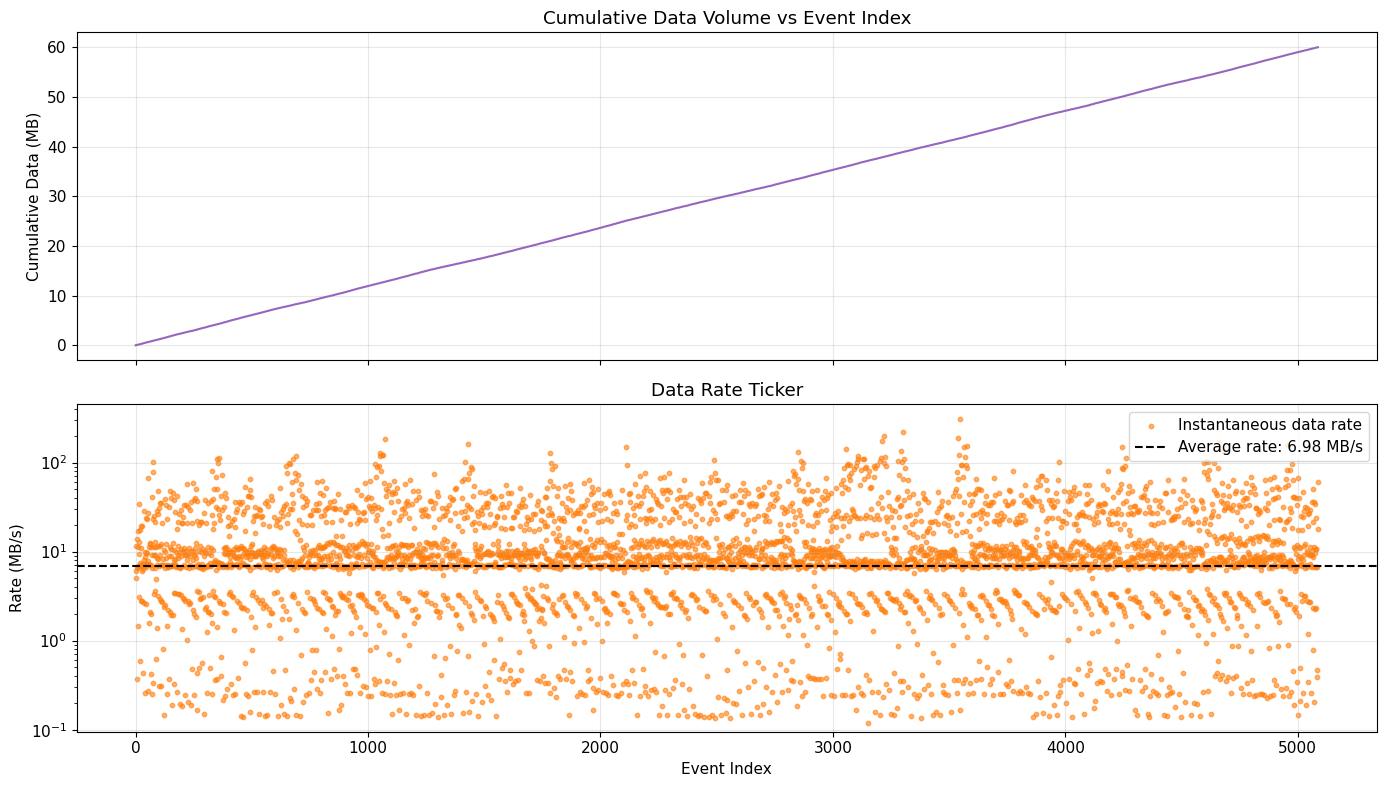

In [12]:
if data_rate_bps.size > 0 and data_rate_event_idx.size > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(event_indices, cumulative_data_mb, color='tab:purple')
    axes[0].set_ylabel('Cumulative Data (MB)')
    axes[0].set_title('Cumulative Data Volume vs Event Index')
    axes[0].grid(True, alpha=0.3)

    data_rate_mb = data_rate_bps * 1e-6
    axes[1].scatter(data_rate_event_idx, data_rate_mb, s=10, alpha=0.6, color='tab:orange', label='Instantaneous data rate')
    if np.isfinite(avg_data_rate_bps):
        axes[1].axhline(avg_data_rate_bps * 1e-6, color='black', linestyle='--', label=f'Average rate: {avg_data_rate_bps * 1e-6:.2f} MB/s')
    axes[1].set_xlabel('Event Index')
    axes[1].set_ylabel('Rate (MB/s)')
    axes[1].set_title('Data Rate Ticker')

    positive_data_rates = data_rate_mb[np.isfinite(data_rate_mb) & (data_rate_mb > 0)]
    if positive_data_rates.size > 0:
        ymin = max(positive_data_rates.min() * 0.8, 1e-6)
        axes[1].set_yscale('log')
        axes[1].set_ylim(bottom=ymin)
    else:
        axes[1].set_ylim(bottom=0)

    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print('Not enough data to compute data rates.')

## Data Rate Histogram

Histogram of per-event data throughput (MB/s) for quick inspection of bandwidth spread.

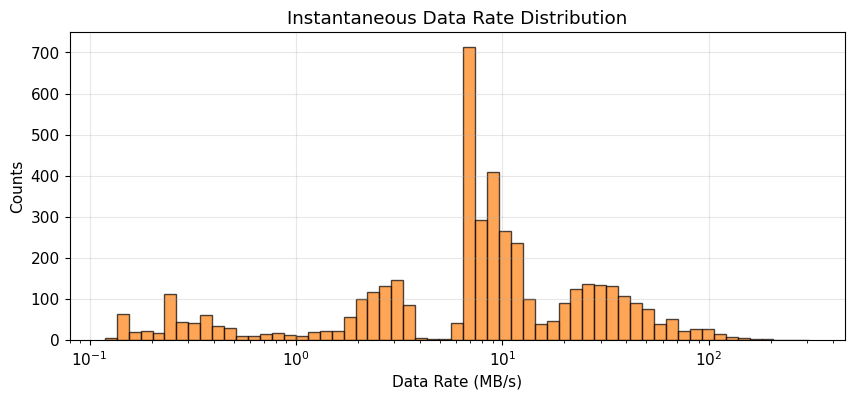

In [13]:
data_rate_mb = data_rate_bps * 1e-6
positive_data_rates = data_rate_mb[np.isfinite(data_rate_mb) & (data_rate_mb > 0)]
if positive_data_rates.size > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    rate_min = positive_data_rates.min()
    rate_max = positive_data_rates.max()
    if rate_min > 0 and rate_max > rate_min:
        bins = np.logspace(np.log10(rate_min), np.log10(rate_max), 60)
        ax.hist(positive_data_rates, bins=bins, color='tab:orange', alpha=0.7, edgecolor='black')
        ax.set_xscale('log')
    else:
        ax.hist(positive_data_rates, bins=40, color='tab:orange', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Data Rate (MB/s)')
    ax.set_ylabel('Counts')
    ax.set_title('Instantaneous Data Rate Distribution')
    ax.grid(True, alpha=0.3)
else:
    print('No positive data rates available for histogram.')

## Summary Statistics

In [14]:
print("=" * 60)
print("EVENT TIMING STATISTICS (microseconds)")
print("=" * 60)
print(f"{'Phase':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 60)
print(f"{'Prepare':<15} {np.mean(et_prepare_max):>10.2f} {np.std(et_prepare_max):>10.2f} {np.min(et_prepare_max):>10.2f} {np.max(et_prepare_max):>10.2f}")
print(f"{'Read':<15} {np.mean(et_read_max):>10.2f} {np.std(et_read_max):>10.2f} {np.min(et_read_max):>10.2f} {np.max(et_read_max):>10.2f}")
print(f"{'Decode':<15} {np.mean(et_decode_max):>10.2f} {np.std(et_decode_max):>10.2f} {np.min(et_decode_max):>10.2f} {np.max(et_decode_max):>10.2f}")
print(f"{'Total':<15} {np.mean(et_total_max):>10.2f} {np.std(et_total_max):>10.2f} {np.min(et_total_max):>10.2f} {np.max(et_total_max):>10.2f}")
print("=" * 60)

if len(ct_total) > 0:
    print()
    print("=" * 60)
    print("COLLECTOR TIMING STATISTICS (microseconds)")
    print("=" * 60)
    print(f"{'Phase':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print("-" * 60)
    print(f"{'Wait':<15} {np.mean(ct_wait):>10.2f} {np.std(ct_wait):>10.2f} {np.min(ct_wait):>10.2f} {np.max(ct_wait):>10.2f}")
    print(f"{'Group':<15} {np.mean(ct_group):>10.2f} {np.std(ct_group):>10.2f} {np.min(ct_group):>10.2f} {np.max(ct_group):>10.2f}")
    print(f"{'Finalize':<15} {np.mean(ct_finalize):>10.2f} {np.std(ct_finalize):>10.2f} {np.min(ct_finalize):>10.2f} {np.max(ct_finalize):>10.2f}")
    print(f"{'Total':<15} {np.mean(ct_total):>10.2f} {np.std(ct_total):>10.2f} {np.min(ct_total):>10.2f} {np.max(ct_total):>10.2f}")
    print("=" * 60)
    print()
    print(f"Collector cycles present: {present_count} ({collector_fraction:.2f}% of events)")
    print(f"Average events per cycle: {np.mean(ct_n_events):.1f}")
    print(f"Average hits per cycle: {np.mean(ct_total_hits):.1f}")

if np.isfinite(total_span_s):
    print(f"Acquisition span: {total_span_s:.2f} s")
else:
    print('Acquisition span: N/A')

if np.isfinite(avg_event_rate_hz):
    print(f"Average event rate: {avg_event_rate_hz:.2f} Hz")
else:
    print('Average event rate: N/A')

if np.isfinite(avg_hit_rate_hz):
    print(f"Average hit rate: {avg_hit_rate_hz:.2f} Hz")
else:
    print('Average hit rate: N/A')

if total_data_bytes > 0:
    print(f"Total data volume: {total_data_bytes / 1e9:.3f} GB")
else:
    print('Total data volume: N/A')

if np.isfinite(avg_data_rate_bps):
    print(f"Average data rate: {avg_data_rate_bps / 1e6:.2f} MB/s ({avg_data_rate_bps:.0f} B/s)")
else:
    print('Average data rate: N/A')


EVENT TIMING STATISTICS (microseconds)
Phase                 Mean        Std        Min        Max
------------------------------------------------------------
Prepare               0.06       0.69       0.00      21.00
Read                 64.08      26.59       8.00     257.00
Decode              205.86      57.65      70.00     421.00
Total              2060.88     938.82      79.00    5853.00

COLLECTOR TIMING STATISTICS (microseconds)
Phase                 Mean        Std        Min        Max
------------------------------------------------------------
Wait               1570.15    1132.93       0.00    5203.00
Group                13.82       8.07       3.00     323.00
Finalize             24.87      13.02       4.00     335.00
Total              1619.80    1141.00      13.00    5287.00

Collector cycles present: 4469 (87.83% of events)
Average events per cycle: 1.1
Average hits per cycle: 38.7
Acquisition span: 8.60 s
Average event rate: 591.78 Hz
Average hit rate: 20127.55 Hz
